# Extraction Piepline

## Setup

In [ ]:
# =========================
# Colab setup (one-time)
# =========================
!pip -q install google-cloud-bigquery google-cloud-storage pyarrow db-dtypes

In [ ]:
import os, re
from typing import Dict
from datetime import datetime
import pyarrow.parquet as pq

from google.cloud import bigquery, storage

# --- Auth: pick one ---
# 1) Service account JSON you uploaded to /content/gcp-key.json
SERVICE_ACCOUNT_KEY = "/content/gcp-key.json"
if os.path.exists(SERVICE_ACCOUNT_KEY):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SERVICE_ACCOUNT_KEY
else:
    # 2) Interactive Colab login (if you don't use a key file)
    try:
        from google.colab import auth
        auth.authenticate_user()
        print("✔ Authenticated with Colab user account")
    except Exception as e:
        print("⚠ Could not do Colab auth automatically. If using a key file, upload it as /content/gcp-key.json.")

In [ ]:
# =========================
# CONFIG — EDIT THESE
# =========================
PROJECT_ID         = "digimusketeers-project"
BQ_DATASET         = "facebook_ads"               # source dataset
BQ_TABLE_PREFIX    = "FBADS_AGE_GENDER_"            # reads from ...FBADS_AD_LEVEL_* .. FBADS_AGE_GENDER_*
DATE_START         = "20210101"
DATE_END           = "20250630"
BQ_LOCATION        = "asia-southeast1"            # must match dataset location

# Temp dataset to materialize per-company tables (auto-created if missing)
TEMP_DATASET       = "facebook_ads_tmp"

GCS_BUCKET         = "digi-datasets-ml"
GCS_BASE_PREFIX    = "facebook-age-temp"
GROUP_BY_TYPE      = False                        # put outputs under business type folders?
PROFILE_COLUMN     = "profile"
DROP_TEMP_TABLES   = True                         # set False to inspect temp tables
DO_ROWCOUNT        = False                        # quick count before export (optional)


In [ ]:
# =========================
# Companies (your mapping)
# =========================
business_type_mapping: Dict[str, str] = {
    # Shopping Malls & Retail Chains
    # 'central': 'retail_brand',
    # 'bebeplay': 'retail_brand',
    'long lasting': 'retail_brand',
    'nitori': 'retail_brand',
    'zhulian': 'retail_brand',
    'ielleair': 'retail_brand',
    'vetz petz': 'retail_brand',
    'kanekoji': 'retail_brand',
    'kamedis': 'retail_brand',

    # Real Estate & Property Development
    'sena development': 'real_estate',
    'sena developmant': 'real_estate',
    'onerealestate': 'real_estate',
    'jsp property': 'real_estate',
    'jsp property x sena': 'real_estate',
    'nusasiri': 'real_estate',
    'premium place': 'real_estate',
    'urban': 'real_estate',
    'pieamsuk': 'real_estate',
    'asakan': 'real_estate',
    'cpn': 'real_estate',
    'wt land development (2024)': 'real_estate',
    'property client (ex.the fine)': 'real_estate',
    'the fine': 'real_estate',
    'colour development': 'real_estate',
    'banmae villa': 'real_estate',
    'varintorn l as vibhavadi l brand': 'real_estate',
    'inspired': 'real_estate',
    'goldenduck': 'real_estate',
    'chewa x c - pk': 'real_estate',

    # Fashion & Lifestyle
    'samsonite': 'fashion_lifestyle',
    'do day dream': 'fashion_lifestyle',
    'ido day dream': 'fashion_lifestyle',
    'ido day dream i valeraswiss thailand i brand [2025]': 'fashion_lifestyle',
    'fila': 'fashion_lifestyle',
    'playboy': 'fashion_lifestyle',
    'what a girl want': 'fashion_lifestyle',
    'rich sport': 'fashion_lifestyle',
    'heydude': 'fashion_lifestyle',

    # Beauty & Cosmetics
    'bb care': 'beauty_cosmetics',
    'reuse': 'beauty_cosmetics',
    'dedvelvet': 'beauty_cosmetics',
    'riobeauty': 'beauty_cosmetics',
    'kameko': 'beauty_cosmetics',
    'befita': 'beauty_cosmetics',
    'vitablend': 'beauty_cosmetics',

    # Healthcare & Medical
    'abl clinic': 'healthcare_medical',
    'luxury clinic': 'healthcare_medical',
    'mane clinic': 'healthcare_medical',
    'dentalme clinic': 'healthcare_medical',
    'mild clinic': 'healthcare_medical',
    'aestheta wellness': 'healthcare_medical',
    'luxury club skin': 'healthcare_medical',

    # Technology & Electronics
    'kangyonglaundry': 'technology_electronics',
    'bosch': 'technology_electronics',
    'amazfit': 'technology_electronics',
    'panduit': 'technology_electronics',
    'mitsubishi electric x digimusketeers': 'technology_electronics',
    'asiasoft digital marketing (center)': 'technology_electronics',
    'at home thailand': 'technology_electronics',
    'sinthanee group': 'technology_electronics',
    'noventiq th': 'technology_electronics',
    'blaupunk l blaupunk l brand': 'technology_electronics',
    'yip in tsoi': 'technology_electronics',

    # Digital Marketing & Agencies
    'digimusketeers': 'digital_marketing',
    'set x digimusketeers': 'digital_marketing',
    'we are innosense co., ltd. v.2': 'digital_marketing',

    # Software Development
    'dspace': 'software_development',
    'midas': 'software_development',
    'launch platform': 'software_development',

    # Financial Services
    'cimb': 'financial_services',
    'tisco ppk': 'financial_services',
    'tisco - insure': 'financial_services',
    'gsb society': 'financial_services',
    'aslan investor': 'financial_services',
    'aeon': 'financial_services',
    'proprakan': 'financial_services',

    # Entertainment & Media
    'donut bangkok': 'entertainment_media',
    'i have ticket': 'entertainment_media',
    'ondemand l ondemand l brand': 'entertainment_media',

    # Food & Beverage
    'ramendesu': 'food_beverage',
    'nomimashou': 'food_beverage',
    'oakberry': 'food_beverage',

    # Transportation & Logistics
    'paypoint': 'transportation_logistics',
    'asia cab': 'transportation_logistics',
    'uac': 'transportation_logistics',
    'artralux': 'transportation_logistics',
    'artralux (social media project)': 'transportation_logistics',
    'siamwatercraft': 'transportation_logistics',

    # Pharmaceuticals & Health Products
    'inpac pharma': 'pharmaceuticals',

    # Non-Profit & Organizations
    'unhcr': 'non_profit',

    # Construction & Manufacturing
    'arun plus ptt': 'industrial_manufacturing',
    'scg': 'industrial_manufacturing',

    # Others/Uncategorized
    'free 657,00 thb': 'other',
}


## Helper

In [ ]:
# =========================
# Helpers
# =========================
def slugify_for_gcs(name: str) -> str:
    s = re.sub(r"[|/\\\s]+", "-", name.strip().lower())
    s = re.sub(r"[^a-z0-9\-_]+", "", s)
    return re.sub(r"-{2,}", "-", s).strip("-") or "unknown"

def slugify_for_bq_table(name: str) -> str:
    s = re.sub(r"[^a-zA-Z0-9_]", "_", name.strip().lower())
    s = re.sub(r"_+", "_", s).strip("_")
    if not s or s[0].isdigit():
        s = f"c_{s}"
    return s[:250]  # stay well under limits

def gcs_prefix_for(company: str, business_type: str) -> str:
    base = f"{GCS_BASE_PREFIX}/"
    if GROUP_BY_TYPE:
        base += f"{business_type}/"
    slug = slugify_for_gcs(company)
    return f"{base}{slug}_profile_{DATE_START}_{DATE_END}"

def ensure_dataset(client: bigquery.Client, dataset_id: str):
    ds_ref = bigquery.Dataset(f"{PROJECT_ID}.{dataset_id}")
    try:
        client.get_dataset(ds_ref)
    except Exception:
        ds_ref.location = BQ_LOCATION
        client.create_dataset(ds_ref)
        print(f"✔ Created dataset {PROJECT_ID}.{dataset_id} in {BQ_LOCATION}")

def count_rows_for_company(bq: bigquery.Client, company: str) -> int:
    q = f"""
    SELECT COUNT(*) AS c
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PREFIX}*`
    WHERE _TABLE_SUFFIX BETWEEN @start AND @end
      AND (LOWER({PROFILE_COLUMN}) LIKE CONCAT(@c, '%')
           OR LOWER({PROFILE_COLUMN}) LIKE CONCAT('|', @c, '%'))
    """
    cfg = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("start", "STRING", DATE_START),
            bigquery.ScalarQueryParameter("end", "STRING", DATE_END),
            bigquery.ScalarQueryParameter("c", "STRING", company.strip().lower()),
        ]
    )
    rows = list(bq.query(q, job_config=cfg, location=BQ_LOCATION).result())
    return int(rows[0]["c"]) if rows else 0

def materialize_then_export(
    bq: bigquery.Client,
    company: str,
    business_type: str
) -> str:
    """
    1) CREATE OR REPLACE TABLE tmp AS SELECT ... FROM wildcard
    2) EXPORT DATA AS SELECT * FROM tmp
    3) DROP TABLE tmp (optional)
    Returns: gs prefix used (without wildcard).
    """
    ensure_dataset(bq, TEMP_DATASET)

    table_slug = slugify_for_bq_table(company)
    temp_table = f"{PROJECT_ID}.{TEMP_DATASET}.tmp_{table_slug}_{DATE_START}_{DATE_END}"

    # 1) Materialize from wildcard into a real table
    create_sql = f"""
    CREATE OR REPLACE TABLE `{temp_table}`
    OPTIONS(expiration_timestamp=TIMESTAMP_ADD(CURRENT_TIMESTAMP(), INTERVAL 24 HOUR)) AS
    SELECT *
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_PREFIX}*`
    WHERE _TABLE_SUFFIX BETWEEN @start AND @end
      AND (LOWER({PROFILE_COLUMN}) LIKE CONCAT(@c, '%')
           OR LOWER({PROFILE_COLUMN}) LIKE CONCAT('|', @c, '%'))
    """
    job_cfg = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("start", "STRING", DATE_START),
            bigquery.ScalarQueryParameter("end", "STRING", DATE_END),
            bigquery.ScalarQueryParameter("c", "STRING", company.strip().lower()),
        ]
    )
    bq.query(create_sql, job_config=job_cfg, location=BQ_LOCATION).result()
    print(f"✔ Materialized: {temp_table}")

    # 2) EXPORT from the materialized table (no wildcard here)
    prefix = gcs_prefix_for(company, business_type)
    uri = f"gs://{GCS_BUCKET}/{prefix}*.parquet"

    export_sql = f"""
    EXPORT DATA OPTIONS (
        uri = @uri,
        format = 'PARQUET',
        overwrite = TRUE
    ) AS
    SELECT * FROM `{temp_table}`
    """
    export_cfg = bigquery.QueryJobConfig(
        query_parameters=[bigquery.ScalarQueryParameter("uri", "STRING", uri)]
    )
    bq.query(export_sql, job_config=export_cfg, location=BQ_LOCATION).result()
    print(f"✔ Exported to {uri}")

    # 3) Drop temp table if desired (we also set a 24h expiration for safety)
    if DROP_TEMP_TABLES:
        drop_sql = f"DROP TABLE `{temp_table}`"
        bq.query(drop_sql, location=BQ_LOCATION).result()
        print(f"🧹 Dropped: {temp_table}")

    return prefix

def merge_parquet_to_single_file_memory_safe(
    storage_client: storage.Client,
    bucket_name: str,
    source_prefix: str,
    destination_blob_name: str,
    delete_shards_after_merge: bool = True,
):
    """
    Merge Parquet shards under `gs://bucket/source_prefix*.parquet` into
    one file at `gs://bucket/destination_blob_name` (PyArrow, streaming).
    If `delete_shards_after_merge` is True, deletes the source shards after upload.
    """

    bucket = storage_client.bucket(bucket_name)

    # Collect only shard files; exclude any previous merged file
    parquet_blobs = []
    for b in bucket.list_blobs(prefix=source_prefix):
        name = b.name
        if not name.endswith(".parquet"):
            continue
        if name == destination_blob_name or name.endswith("_merged.parquet"):
            # avoid re-reading an old merged file
            continue
        parquet_blobs.append(b)

    if not parquet_blobs:
        print(f"⚠ No shard parquet files found for gs://{bucket_name}/{source_prefix}")
        return

    print(f"⏳ Merging {len(parquet_blobs)} shard(s) for prefix '{source_prefix}' ...")

    tmp_local = "/content/_merged_tmp.parquet"
    if os.path.exists(tmp_local):
        os.remove(tmp_local)

    schema = None
    writer = None
    try:
        # Stream shards into a single Parquet
        for i, b in enumerate(parquet_blobs, start=1):
            with b.open("rb") as f:
                table = pq.read_table(f)
            if schema is None:
                schema = table.schema
                writer = pq.ParquetWriter(tmp_local, schema)
            else:
                table = table.cast(schema, safe=False)  # align columns if needed
            writer.write_table(table)
            if i % 10 == 0 or i == len(parquet_blobs):
                print(f"  • processed {i}/{len(parquet_blobs)}")

        if writer is not None:
            writer.close()

        # Upload merged file
        dest_blob = bucket.blob(destination_blob_name)
        with open(tmp_local, "rb") as f:
            dest_blob.upload_from_file(f, rewind=True)

        print(f"✔ Saved merged file: gs://{bucket_name}/{destination_blob_name}")

        # Delete shards after successful upload
        if delete_shards_after_merge:
            deleted = 0
            for b in parquet_blobs:
                try:
                    b.delete()
                    deleted += 1
                except Exception as de:
                    print(f"   ⚠ Could not delete {b.name}: {de}")
            print(f"🧹 Deleted {deleted}/{len(parquet_blobs)} shard(s).")

    finally:
        try:
            if writer is not None:
                writer.close()
        except:
            pass
        if os.path.exists(tmp_local):
            os.remove(tmp_local)


## Run the pipeline

In [ ]:
# =========================
# Run the pipeline
# =========================
bqclient = bigquery.Client(project=PROJECT_ID)
gcs_client = storage.Client(project=PROJECT_ID)

start_time = datetime.now()
print(f"▶ Run started at {start_time}")

for company, biz_type in business_type_mapping.items():
    try:
        if DO_ROWCOUNT:
            cnt = count_rows_for_company(bqclient, company)
            print(f"{company!r} rows = {cnt}")
            if cnt == 0:
                print(f"↳ Skip (no rows)\n")
                continue

        # 1) Materialize + Export
        source_prefix = materialize_then_export(bqclient, company, biz_type)

        # 2) Merge shards → single parquet
        merged_blob = f"{source_prefix}_merged.parquet"
        merge_parquet_to_single_file_memory_safe(
            gcs_client,
            GCS_BUCKET,
            source_prefix,
            merged_blob,
            delete_shards_after_merge=True,   # ← deletes the shards after merge
        )
        print()
    except Exception as e:
        print(f"❌ Error for {company!r}: {e}\n")

end_time = datetime.now()
print(f"⏹ Finished at {end_time} (duration {end_time - start_time})")


▶ Run started at 2025-09-03 02:53:46.299777
✔ Materialized: digimusketeers-project.facebook_ads_tmp.tmp_long_lasting_20210101_20250630
✔ Exported to gs://digi-datasets-ml/facebook-age-temp/long-lasting_profile_20210101_20250630*.parquet
🧹 Dropped: digimusketeers-project.facebook_ads_tmp.tmp_long_lasting_20210101_20250630
⏳ Merging 1 shard(s) for prefix 'facebook-age-temp/long-lasting_profile_20210101_20250630' ...
  • processed 1/1
✔ Saved merged file: gs://digi-datasets-ml/facebook-age-temp/long-lasting_profile_20210101_20250630_merged.parquet
🧹 Deleted 1/1 shard(s).

✔ Materialized: digimusketeers-project.facebook_ads_tmp.tmp_nitori_20210101_20250630
✔ Exported to gs://digi-datasets-ml/facebook-age-temp/nitori_profile_20210101_20250630*.parquet
🧹 Dropped: digimusketeers-project.facebook_ads_tmp.tmp_nitori_20210101_20250630
⏳ Merging 1 shard(s) for prefix 'facebook-age-temp/nitori_profile_20210101_20250630' ...
  • processed 1/1
✔ Saved merged file: gs://digi-datasets-ml/facebook-age-

# Many Parquet to Single File

## Helper

In [ ]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
from google.cloud import storage
from datetime import datetime

def merge_many_parquet_files_to_single_gcs_safe(
    storage_client: storage.Client,
    bucket_name: str,
    base_prefix: str,          # e.g. 'facebook-ads'
    per_company_suffix: str,   # e.g. f"_profile_{DATE_START}_{DATE_END}_merged.parquet"
    output_blob_name: str,     # e.g. 'facebook-ads/facebook_ads__20210101_20250630.parquet'
    overwrite: bool = False,   # protect against accidental overwrite
):
    """
    READ-ONLY merge: finds all per-company merged Parquet files under gs://bucket/<base_prefix>/
    that end with `per_company_suffix`, unifies schemas, and writes a single Parquet to `output_blob_name`.

    SAFETY:
      - Never deletes or mutates input files.
      - If overwrite=False and the output already exists, raises an error instead of overwriting.
    """
    bucket = storage_client.bucket(bucket_name)

    # Safety: don't overwrite combined file by default
    dest_blob = bucket.blob(output_blob_name)
    if dest_blob.exists() and not overwrite:
        raise RuntimeError(
            f"Output exists and overwrite=False: gs://{bucket_name}/{output_blob_name}"
        )

    # Find only the date-window files we want
    scan_prefix = base_prefix.rstrip("/") + "/"
    inputs = []
    for b in bucket.list_blobs(prefix=scan_prefix):
        name = b.name
        if name.endswith(per_company_suffix) and name != output_blob_name:
            inputs.append(b)

    # Keep deterministic order (optional)
    inputs.sort(key=lambda b: b.name)

    if not inputs:
        raise RuntimeError(
            f"No input files matched suffix '{per_company_suffix}' under gs://{bucket_name}/{scan_prefix}"
        )

    print(f"Found {len(inputs)} per-company files to merge (read-only).")

    # Build union schema across inputs (robust to drift)
    schemas = []
    rowcounts = []
    for b in inputs:
        with b.open("rb") as f:
            pf = pq.ParquetFile(f)
            schemas.append(pf.schema_arrow)
            # metadata row count (fast, no full read)
            rc = sum(pf.metadata.row_group(i).num_rows for i in range(pf.metadata.num_row_groups))
            rowcounts.append(rc)

    union_schema = pa.unify_schemas(schemas)
    print(f"Union schema has {len(union_schema)} columns.")
    print(f"Approx. total rows across inputs: {sum(rowcounts):,}")

    # Stream into one local parquet (memory-safe)
    tmp_local = "/content/_ALL_FACEBOOK_ADS.parquet"
    if os.path.exists(tmp_local):
        os.remove(tmp_local)

    writer = None
    written_rows = 0
    try:
        for idx, b in enumerate(inputs, start=1):
            with b.open("rb") as f:
                pf = pq.ParquetFile(f)

                for rg in range(pf.num_row_groups):
                    tbl = pf.read_row_group(rg)

                    # Align to union schema
                    arrays = []
                    for field in union_schema:
                        name = field.name
                        if name in tbl.column_names:
                            col = tbl[name]
                            if not col.type.equals(field.type):
                                col = col.cast(field.type, safe=False)
                            arrays.append(col)
                        else:
                            arrays.append(pa.nulls(tbl.num_rows, type=field.type))

                    out_tbl = pa.Table.from_arrays(arrays, schema=union_schema)
                    if writer is None:
                        writer = pq.ParquetWriter(tmp_local, union_schema)
                    writer.write_table(out_tbl)
                    written_rows += out_tbl.num_rows

            if idx % 5 == 0 or idx == len(inputs):
                print(f"  • processed {idx}/{len(inputs)} files")

        if writer is not None:
            writer.close()

        # Upload the combined file
        with open(tmp_local, "rb") as f:
            dest_blob.upload_from_file(f, rewind=True)

        print(f"✔ Wrote {written_rows:,} rows to gs://{bucket_name}/{output_blob_name}")
        print("🔒 Inputs were not deleted or modified.")
    finally:
        try:
            if writer is not None:
                writer.close()
        except:
            pass
        if os.path.exists(tmp_local):
            os.remove(tmp_local)



In [ ]:

# ---- Run it (READ-ONLY merge) ----

bqclient = bigquery.Client(project=PROJECT_ID)
gcs_client = storage.Client(project=PROJECT_ID)

start_time = datetime.now()
print(f"▶ Run started at {start_time}")

ALL_OUT_BLOB = f"{GCS_BASE_PREFIX}/facebook_ads__{DATE_START}_{DATE_END}.parquet"
PER_COMPANY_SUFFIX = f"_profile_{DATE_START}_{DATE_END}_merged.parquet"

merge_many_parquet_files_to_single_gcs_safe(
    storage_client=gcs_client,
    bucket_name=GCS_BUCKET,
    base_prefix=GCS_BASE_PREFIX,
    per_company_suffix=PER_COMPANY_SUFFIX,
    output_blob_name=ALL_OUT_BLOB,
    overwrite=False,   # keep this False to avoid overwriting an existing combined file
)

end_time = datetime.now()
print(f"⏹ Finished at {end_time} (duration {end_time - start_time})")


▶ Run started at 2025-09-01 05:14:12.848033
Found 93 per-company files to merge (read-only).
Union schema has 92 columns.
Approx. total rows across inputs: 18,452,736
  • processed 5/93 files
  • processed 10/93 files
  • processed 15/93 files
  • processed 20/93 files
  • processed 25/93 files
  • processed 30/93 files
  • processed 35/93 files
  • processed 40/93 files
  • processed 45/93 files
  • processed 50/93 files
  • processed 55/93 files
  • processed 60/93 files
  • processed 65/93 files
  • processed 70/93 files
  • processed 75/93 files
  • processed 80/93 files
  • processed 85/93 files
  • processed 90/93 files
  • processed 93/93 files
✔ Wrote 18,452,736 rows to gs://digi-datasets-ml/facebook-ads-temp/facebook_ads__20210101_20250630.parquet
🔒 Inputs were not deleted or modified.
⏹ Finished at 2025-09-01 05:16:13.063110 (duration 0:02:00.215077)


# Download File to Colab

In [2]:
!gcloud auth activate-service-account --key-file=/content/gcp-key.json
REMOTE="gs://digi-datasets-ml/facebook-ads/facebook_ads__20210101_20250630.parquet"
!gsutil cp "$REMOTE" /content/
!ls -lh /content/facebook_ads__20210101_20250630.parquet


Activated service account credentials for: [docker-bigquery-runner@digimusketeers-project.iam.gserviceaccount.com]
Copying gs://digi-datasets-ml/facebook-ads/facebook_ads__20210101_20250630.parquet...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][738.6 MiB/738.6 MiB]   21.8 MiB/s                                   
Operation completed over 1 objects/738.6 MiB.                                    
-rw-r--r-- 1 root root 739M Sep  8 02:34 /content/facebook_ads__20210101_20250630.parquet


In [ ]:
df = pl.read_parquet("/content/facebook_ads__20210101_20250630.parquet")
df.columns

['profile_id',
 'profile',
 'ad_id',
 'ad_name',
 'campaign_id',
 'campaign_name',
 'ad_group_id',
 'ad_group_name',
 'ad_group_daily_budget',
 'ad_group_end_date',
 'ad_group_lifetime_budget',
 'ad_group_start_date',
 'campaign_end_date',
 'campaign_start_date',
 'campaign_buying_type',
 'campaign_configured_status',
 'campaign_objective',
 'campaign_status',
 'creative_call_to_action_type',
 'creative_object_url',
 'creative_template_url',
 'date',
 'destination_url',
 'impression_device',
 'promoted_post_permalink_url',
 'promoted_post_permalink_ig_url',
 'utm_campaign',
 'utm_content',
 'utm_medium',
 'utm_source',
 'utm_term',
 'action_checkin',
 'action_comment',
 'action_leadgen_other',
 'action_like',
 'action_link_click',
 'action_mobile_app_install',
 'action_page_engagement',
 'action_photo_view',
 'action_post',
 'action_post_engagement',
 'action_post_like',
 'action_rsvp',
 'action_video_play',
 'action_video_view',
 'actions',
 'action_value',
 'blocked_message_conversat

# ML Pipeline

## DATA LOADING & PREPARATION

In [3]:
!python fbads_bu_time_features_filt.py \
  --input "/content/facebook_ads__20210101_20250630.parquet" \
  --output "/content/fbads_prepared_begin.parquet" \
  --engine gpu

Polars: 1.25.2
Input : /content/facebook_ads__20210101_20250630.parquet
Output: /content/fbads_prepared_begin.parquet
Engine: gpu (prefer GPU: True)
Using cols: ['profile', 'campaign_objective', 'creative_call_to_action_type', 'impression_device', 'ad_group_start_date', 'ad_group_end_date', 'campaign_start_date', 'campaign_end_date', 'cost', 'actions', 'clicks', 'impressions', 'conversion_value', 'reach']
Adding business type mapping...
Keeping 100 columns: 95 X features + 5 Y targets
✅ Done in 65.5s | rows=18,452,736 cols=100
Saved → /content/fbads_prepared_begin.parquet

Final dataset:
- X features: 95
- Y targets: 5

Business type distribution:
shape: (15, 2)
┌─────┬─────┐
│ bus ┆ len │
│ ine ┆ --- │
│ ss_ ┆ u32 │
│ typ ┆     │
│ e   ┆     │
│ --- ┆     │
│ str ┆     │
╞═════╪═════╡
│ ret ┆ 540 │
│ ail ┆ 651 │
│ _br ┆ 8   │
│ and ┆     │
│ rea ┆ 484 │
│ l_e ┆ 173 │
│ sta ┆ 4   │
│ te  ┆     │
│ fas ┆ 465 │
│ hio ┆ 064 │
│ n_l ┆ 2   │
│ ife ┆     │
│ sty ┆     │
│ le  ┆     │
│ dig ┆

In [ ]:
import polars as pl
df = pl.read_parquet("/content/fbads_prepared_begin.parquet")
df.head()

ad_group_duration,campaign_duration,adg_start_month,adg_start_year4,adg_start_dow,adg_start_weekofyear,adg_start_doy,adg_start_days_in_month,adg_start_dom,adg_start_month_progress,adg_start_quarter,adg_start_is_weekend,adg_start_is_month_start,adg_start_is_month_end,adg_start_month_sin,adg_start_month_cos,adg_start_dow_sin,adg_start_dow_cos,adg_start_doy_sin,adg_start_doy_cos,adg_end_month,adg_end_year4,adg_end_dow,adg_end_weekofyear,adg_end_doy,adg_end_days_in_month,adg_end_dom,adg_end_month_progress,adg_end_quarter,adg_end_is_weekend,adg_end_is_month_start,adg_end_is_month_end,adg_end_month_sin,adg_end_month_cos,adg_end_dow_sin,adg_end_dow_cos,adg_end_doy_sin,…,camp_end_month_progress,camp_end_quarter,camp_end_is_weekend,camp_end_is_month_start,camp_end_is_month_end,camp_end_month_sin,camp_end_month_cos,camp_end_dow_sin,camp_end_dow_cos,camp_end_doy_sin,camp_end_doy_cos,adg_start_minus_camp_start_days,camp_end_minus_adg_end_days,adg_start_offset_days,adg_end_offset_days,adg_inside_campaign,adg_duration_ratio,adg_mid_month_sin,adg_mid_month_cos,camp_mid_month_sin,camp_mid_month_cos,adg_cost_per_day,camp_cost_per_day,cost_x_adg_start_month_sin,cost_x_adg_start_month_cos,cost_x_camp_start_month_sin,cost_x_camp_start_month_cos,campaign_objective_norm,cta_type_norm,impression_device_norm,business_type,cost,impressions_log1p,clicks_log1p,actions_log1p,reach_log1p,conversion_value_log1p
i64,i64,i8,i16,i8,i16,i16,i8,i8,f64,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,i8,i16,i8,i16,i16,i8,i8,f64,i8,i8,i8,i8,f64,f64,f64,f64,f64,…,f64,i8,i8,i8,i8,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,f64,f64,f64,f64,f64
32,32,10,2021,1,42,291,31,18,0.548387,4,0,0,0,-0.866025,0.5,0.781831,0.62349,-0.96015,0.279486,11,2021,5,46,323,30,19,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,…,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,0.739689,0,0,0,0,1,1.0,-0.5,0.866025,-0.5,0.866025,13.466875,13.466875,-5.25529,3.034143,-5.25529,3.034143,"""messages""","""message_page""","""iphone""","""healthcare_medical""",430.94,6.986566,3.295837,2.772589,6.588926,0.0
32,32,10,2021,1,42,291,31,18,0.548387,4,0,0,0,-0.866025,0.5,0.781831,0.62349,-0.96015,0.279486,11,2021,5,46,323,30,19,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,…,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,0.739689,0,0,0,0,1,1.0,-0.5,0.866025,-0.5,0.866025,4.921666,4.921666,-4.387036,2.532856,-4.387036,2.532856,"""messages""","""message_page""","""android_smartphone""","""healthcare_medical""",157.4933,6.302619,2.639057,3.091042,6.276643,0.0
32,32,10,2021,1,42,291,31,18,0.548387,4,0,0,0,-0.866025,0.5,0.781831,0.62349,-0.96015,0.279486,11,2021,5,46,323,30,19,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,…,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,0.739689,0,0,0,0,1,1.0,-0.5,0.866025,-0.5,0.866025,15.661563,15.661563,-5.385759,3.109469,-5.385759,3.109469,"""messages""","""message_page""","""iphone""","""healthcare_medical""",501.17,7.110696,3.583519,3.332205,6.685861,0.0
32,32,10,2021,1,42,291,31,18,0.548387,4,0,0,0,-0.866025,0.5,0.781831,0.62349,-0.96015,0.279486,11,2021,5,46,323,30,19,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,…,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,0.739689,0,0,0,0,1,1.0,-0.5,0.866025,-0.5,0.866025,7.3975,7.3975,-4.738106,2.735547,-4.738106,2.735547,"""messages""","""message_page""","""android_smartphone""","""healthcare_medical""",236.72,6.335054,3.332205,3.332205,6.095825,0.0
32,32,10,2021,1,42,291,31,18,0.548387,4,0,0,0,-0.866025,0.5,0.781831,0.62349,-0.96015,0.279486,11,2021,5,46,323,30,19,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,…,0.6,4,1,0,0,-0.5,0.866025,-0.974928,-0.222521,-0.672949,0.739689,0,0,0,0,1,1.0,-0.5,0.866025,-0.5,0.866025,10.595313,10.595313,-5.048142,2.914546,-5.048142,2.914546,"""messages""","""message_page""","""iphone""","""healthcare_medical""",339.05,6.835185,3.496508,3.258097,6.517671,0.0


## Clean Duplicate and Outlier

In [5]:
!python fbads_clean_data.py \
  --input "/content/fbads_prepared_begin.parquet" \
  --output "/content/fbads_clean.parquet" \
  --engine gpu \
  --remove-outliers \
  --contamination 0.05 \
  --outlier-sample-size 100000 \
  --apply-ohe \
  --apply-standardization \
  --copy-chunk-size 150000 \
  --memory-threshold-mb 6000



🚀 GPU-Accelerated Data Cleaning + Preprocessing Pipeline
Polars version: 1.25.2
Input: /content/fbads_prepared_begin.parquet
Output: /content/fbads_clean.parquet
Engine: GPU-preferred
Batch size: 500,000
Final copy chunk size: 150,000
Initial memory usage: 201.7 MB RAM, 0.0 MB GPU
📊 Scanning data: /content/fbads_prepared_begin.parquet
Dataset info:
  - Rows: 18,452,736
  - Columns: 100
  - Estimated memory: 9064.0 MB
After data info: 606.0 MB RAM (+404.3), 628.0 MB GPU


🧹 === Removing Duplicate Rows (GPU-Accelerated) ===
Total rows before deduplication: 18,452,736
📊 Scanning data: /content/fbads_prepared_begin.parquet
Dataset info:
  - Rows: 18,452,736
  - Columns: 100
  - Estimated memory: 9064.0 MB
Processing entire dataset at once...
✅ Deduplication complete:
  Original: 18,452,736 rows
  Unique: 13,154,439 rows
  Removed: 5,298,297 duplicates (28.7%)
After deduplication cleanup: 1102.9 MB RAM, 15092.0 MB GPU
⚠️  HIGH MEMORY USAGE WARNING:
   RAM: 1102.9 MB (2.5% of 45000 MB)
   GP

In [ ]:
import polars as pl
df = pl.read_parquet("/content/fbads_clean.parquet")
df.head()

In [ ]:
print("Null values per column:")
display(df.null_count())

## train model

In [13]:
!python fbads_train_model.py \
  --input /content/fbads_clean.parquet \
  --output-dir ./models_memory_efficient \
  --use-gpu \
  --max-memory-mb 24000 \
  --batch-size 1000000 \
  --test-size 0.15 \
  --val-size 0.15

✅ RAPIDS cuML available
✅ XGBoost GPU support available
✅ LightGBM available (CPU only)
🚀 Memory-Efficient ML Pipeline with Ensemble Learning
Input: /content/fbads_clean.parquet
Output: ./models_memory_efficient
Max Memory: 24000MB
Batch Size: 1000000
Sample Size: All data
Ensemble Methods: ['voting', 'weighted_voting', 'stacking']
Initial memory: 845.2MB
📊 Using user-defined batch size: 1,000,000
📊 Scanning dataset info...
   Total rows (original): 9,264,084
   Total columns: 165
   Batch size: 1,000,000
Available targets: ['impressions_log1p', 'clicks_log1p', 'actions_log1p', 'reach_log1p', 'conversion_value_log1p']
Feature columns: 160
🔀 Creating data splits
   Train indices: 6,484,858
   Val indices: 1,389,613
   Test indices: 1,389,613


Training target: impressions
📥 Loading training data...
📥 Loading 6,484,858 rows, 161 columns
   Processing in batches of 1,000,000
   Loaded batch 1/7: 1000000 rows, Memory: 9838.0MB
   Loaded batch 2/7: 1000000 rows, Memory: 11000.3MB
   Loaded 

## Take a peek

In [14]:
!python fbads_peek_info.py \
    --models-dir /content/models_memory_efficient \
    --output-dir ./analysis_results \
    --create-plots \
    --export-all

🚀 LOADING AND ANALYZING TRAINED MODELS
Models directory: /content/models_memory_efficient
Output directory: ./analysis_results
📂 Loading best_models_info.joblib from /content/models_memory_efficient...
📂 Loading training_metadata.joblib from /content/models_memory_efficient...
✅ Successfully loaded models for 5 targets

🔍 BEST_MODELS_INFO.JOBLIB ANALYSIS
This file contains the BEST model for each target with:
• Model name and file path
• Validation metrics (log and original scale)
• Test metrics (log and original scale)
• Model performance details

📊 Found 5 trained targets:
  impressions          → ensemble_stacking    (Val R²: 0.8738, Test R²: 0.8745)
  clicks               → ensemble_stacking    (Val R²: 0.7017, Test R²: 0.7031)
  actions              → ensemble_stacking    (Val R²: 0.6709, Test R²: 0.6719)
  reach                → ensemble_stacking    (Val R²: 0.8680, Test R²: 0.8686)
  conversion_value     → ensemble_stacking    (Val R²: 0.5436, Test R²: 0.5433)

📈 DETAILED METRIC

## Inference

In [19]:
!python fbads_inference.py \
  --models-dir ./models_memory_efficient \
  --standardization-params /content/fbads_clean_standardization_params.joblib \
  --campaign-start-date "2025-05-06" \
  --campaign-end-date "2025-06-15" \
  --ad-group-start-date "2025-05-06" \
  --ad-group-end-date "2025-06-15" \
  --cost 87.89 \
  --campaign-objective "OUTCOME_TRAFFIC" \
  --cta-type "MESSAGE_PAGE" \
  --impression-device "android_smartphone" \
  --business-type "real_estate" \
  --output-format json

🚀 Loading models and preprocessing parameters...
🔍 Loading models from: ./models_memory_efficient
🔄 Reconstructing ensemble model: impressions (stacking)
   ✅ Loaded base model: sgd_ridge
   ✅ Loaded base model: xgb
   ✅ Loaded base model: lgb
   ✅ Loaded base model: elastic_net
   ✅ Loaded meta-model for stacking
✅ Reconstructed ensemble model: impressions
🔄 Reconstructing ensemble model: clicks (stacking)
   ✅ Loaded base model: sgd_ridge
   ✅ Loaded base model: xgb
   ✅ Loaded base model: lgb
   ✅ Loaded base model: elastic_net
   ✅ Loaded meta-model for stacking
✅ Reconstructed ensemble model: clicks
🔄 Reconstructing ensemble model: actions (stacking)
   ✅ Loaded base model: sgd_ridge
   ✅ Loaded base model: xgb
   ✅ Loaded base model: lgb
   ✅ Loaded base model: elastic_net
   ✅ Loaded meta-model for stacking
✅ Reconstructed ensemble model: actions
🔄 Reconstructing ensemble model: reach (stacking)
   ✅ Loaded base model: sgd_ridge
   ✅ Loaded base model: xgb
   ✅ Loaded base model

# Take a peek on INFO result

In [ ]:
# Get feature names for new data preparation
import joblib
metadata = joblib.load('models_memory_efficient/training_metadata.joblib')

feature_columns = metadata['feature_columns']
print(f"Required features ({len(feature_columns)}):")
for i, feat in enumerate(feature_columns):
    print(f"{i+1:3d}. {feat}")



Required features (160):
  1. ad_group_duration
  2. campaign_duration
  3. adg_start_month
  4. adg_start_year4
  5. adg_start_dow
  6. adg_start_weekofyear
  7. adg_start_doy
  8. adg_start_days_in_month
  9. adg_start_dom
 10. adg_start_month_progress
 11. adg_start_quarter
 12. adg_start_is_weekend
 13. adg_start_is_month_start
 14. adg_start_is_month_end
 15. adg_start_month_sin
 16. adg_start_month_cos
 17. adg_start_dow_sin
 18. adg_start_dow_cos
 19. adg_start_doy_sin
 20. adg_start_doy_cos
 21. adg_end_month
 22. adg_end_year4
 23. adg_end_dow
 24. adg_end_weekofyear
 25. adg_end_doy
 26. adg_end_days_in_month
 27. adg_end_dom
 28. adg_end_month_progress
 29. adg_end_quarter
 30. adg_end_is_weekend
 31. adg_end_is_month_start
 32. adg_end_is_month_end
 33. adg_end_month_sin
 34. adg_end_month_cos
 35. adg_end_dow_sin
 36. adg_end_dow_cos
 37. adg_end_doy_sin
 38. adg_end_doy_cos
 39. camp_start_month
 40. camp_start_year4
 41. camp_start_dow
 42. camp_start_weekofyear
 43. cam

In [20]:
!zip -r models_memory_efficient.zip models_memory_efficient/

from google.colab import files
files.download('models_memory_efficient.zip')

  adding: models_memory_efficient/ (stored 0%)
  adding: models_memory_efficient/base_model_impressions_lgb.joblib (deflated 66%)
  adding: models_memory_efficient/meta_model_actions.joblib (deflated 21%)
  adding: models_memory_efficient/base_model_actions_ridge.joblib (deflated 16%)
  adding: models_memory_efficient/base_model_reach_lgb.joblib (deflated 66%)
  adding: models_memory_efficient/base_model_impressions_xgb.joblib (deflated 70%)
  adding: models_memory_efficient/meta_model_conversion_value.joblib (deflated 21%)
  adding: models_memory_efficient/best_model_actions.joblib (deflated 57%)
  adding: models_memory_efficient/best_models_info.joblib (deflated 52%)
  adding: models_memory_efficient/base_model_conversion_value_ridge.joblib (deflated 16%)
  adding: models_memory_efficient/base_model_reach_elastic_net.joblib (deflated 67%)
  adding: models_memory_efficient/base_model_conversion_value_xgb.joblib (deflated 70%)
  adding: models_memory_efficient/meta_model_clicks.joblib 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

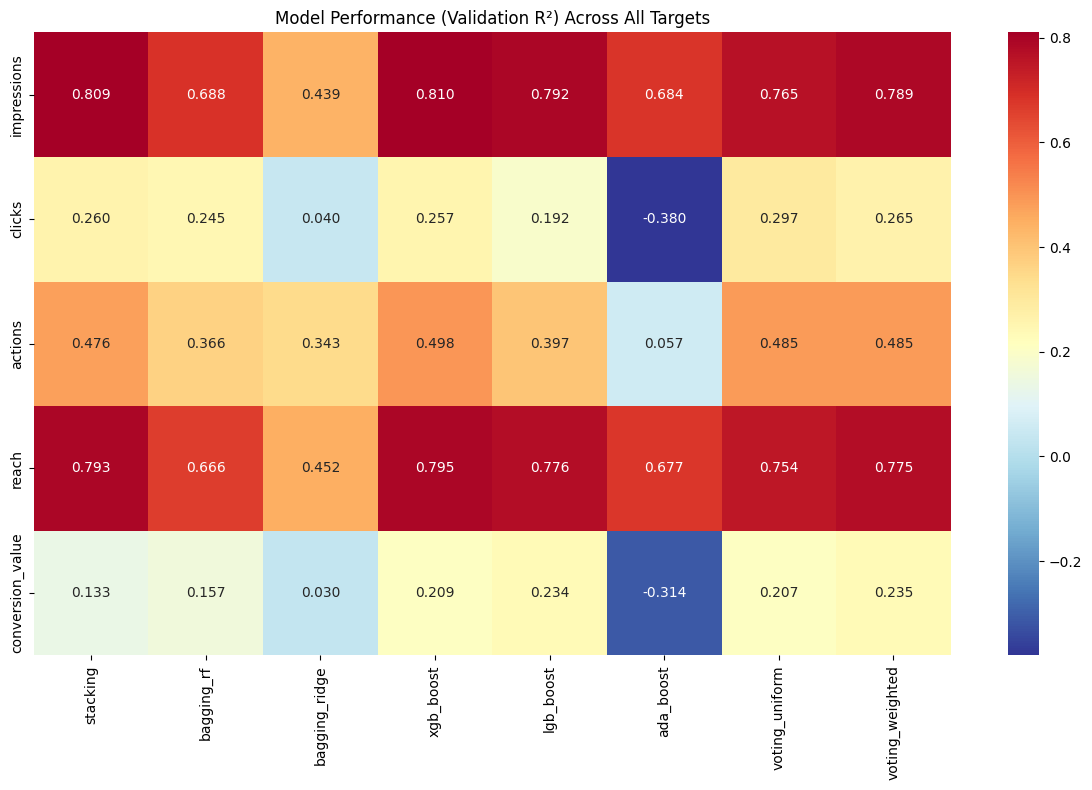

In [ ]:
# Create a heatmap of model performance
import matplotlib.pyplot as plt
import seaborn as sns

comparison_matrix = []
model_names = []
target_names = []

for target, models in metadata['model_comparison'].items():
    if not target_names:  # First iteration
        model_names = list(models.keys())

    target_names.append(target.replace('_log1p', ''))
    row = [models[model]['val']['log_r2'] for model in model_names]
    comparison_matrix.append(row)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(comparison_matrix,
            xticklabels=model_names,
            yticklabels=target_names,
            annot=True, fmt='.3f', cmap='RdYlBu_r')
plt.title('Model Performance (Validation R²) Across All Targets')
plt.tight_layout()
plt.show()